Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense , Activation, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
## Mounting the google drive
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
os.chdir('/content/gdrive/MyDrive/')


Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
   data_dir_train,
   validation_split=0.2,
   subset="training",
   seed=123,
   image_size=(img_height,img_width),
   batch_size=batch_size
)




Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [8]:

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 118 files belonging to 9 classes.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

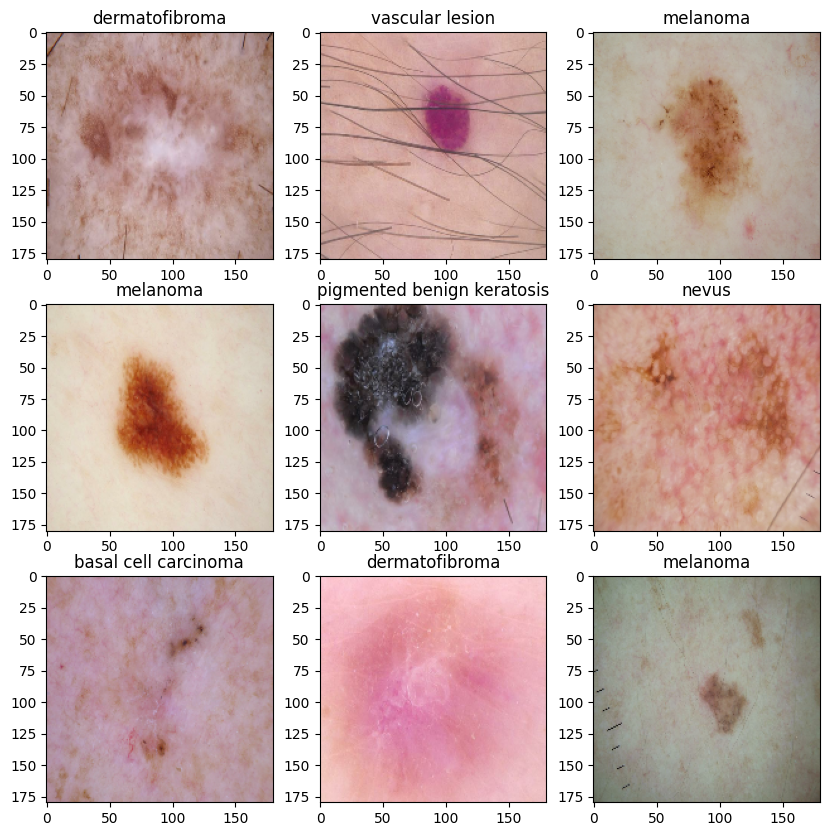

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here

from tensorflow.keras import regularizers

input_shape = (180,180,3)
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3)))
model.add(Conv2D(32, kernel_size=(3,3), padding = 'Same', activation = 'relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), padding = 'Same', activation = 'relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,kernel_size=(3,3),padding = 'Same', activation = 'relu' ))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=(3,3),padding = 'Same', activation = 'relu' ))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation ='relu',kernel_regularizer=regularizers.L2(0.01)))
model.add(Dropout(0.25))
model.add(Dense(9,activation='softmax'))

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 180, 180, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 180, 180, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 180, 180, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 180, 180, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0

### Train the model

In [15]:
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 761s 1s/step - loss: 24.0114 - accuracy: 0.2398 - val_loss: 57.8546 - val_accuracy: 0.1359
Epoch 2/20
169/169 [==============================] - 27s 162ms/step - loss: 6.5222 - accuracy: 0.3244 - val_loss: 17.5361 - val_accuracy: 0.1136
Epoch 3/20
169/169 [==============================] - 28s 164ms/step - loss: 3.0714 - accuracy: 0.3578 - val_loss: 3.5916 - val_accuracy: 0.2650
Epoch 4/20
169/169 [==============================] - 28s 167ms/step - loss: 2.3739 - accuracy: 0.3876 - val_loss: 2.3566 - val_accuracy: 0.3823
Epoch 5/20
169/169 [==============================] - 28s 166ms/step - loss: 2.2289 - accuracy: 0.4008 - val_loss: 2.2472 - val_accuracy: 0.3786
Epoch 6/20
169/169 [==============================] - 28s 165ms/step - loss: 2.0928 - accuracy: 0.3971 - val_loss: 1.9867 - val_accuracy: 0.4417
Epoch 7/20
169/169 [==============================] - 28s 166ms/step - loss: 1.9628 - accuracy: 0.4358 - val_loss: 1.8433 - val_a

### Visualizing training results

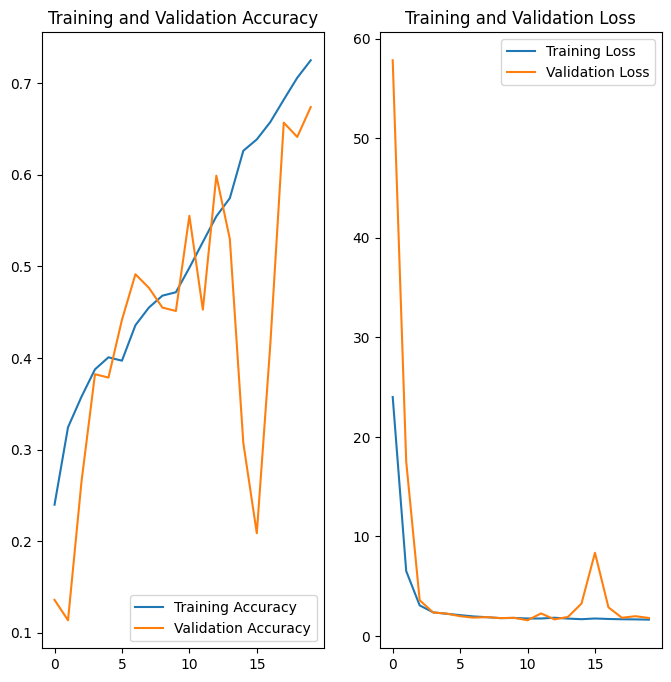

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Findings:
The training accuracy of the model is around 72% which is not good.
The validation accuracy is 67% . Therefore the Model is underfitting.

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                    input_shape=(180,180,3)),
        layers.experimental.preprocessing.RandomRotation(0.2),
        layers.experimental.preprocessing.RandomZoom(0.2),
        layers.experimental.preprocessing.RandomContrast(0.1)

    ]
)

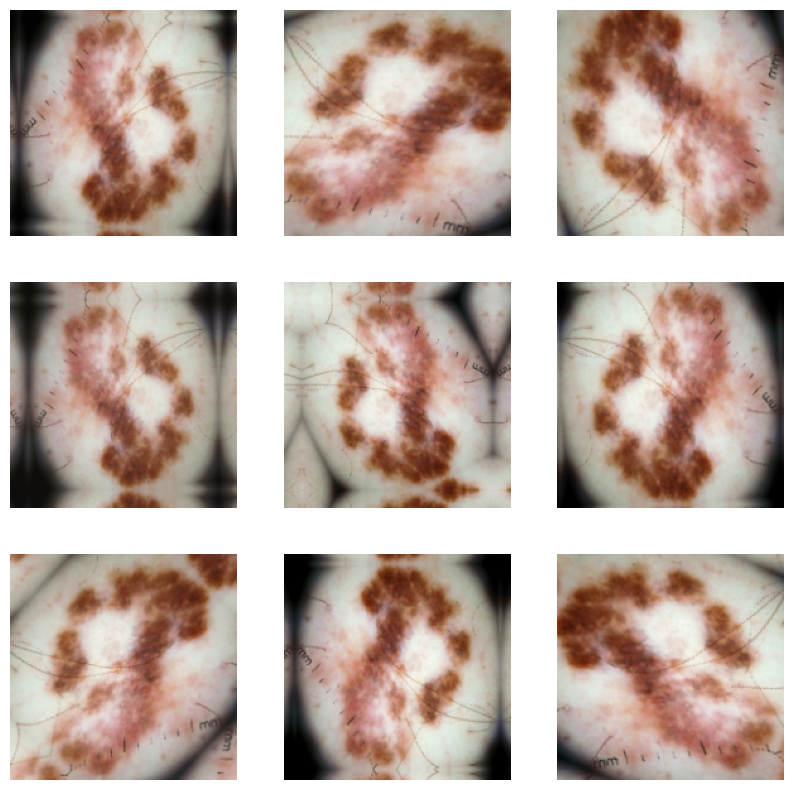

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10,10))

for images,_ in train_ds.take(1):
  for i in range(9):
    augmented_images=data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3)))
model.add(data_augmentation)
model.add(Conv2D(32, kernel_size=(3,3), padding = 'Same', activation = 'relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), padding = 'Same', activation = 'relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,kernel_size=(3,3),padding = 'Same', activation = 'relu' ))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=(3,3),padding = 'Same', activation = 'relu' ))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation ='relu',kernel_regularizer=regularizers.L2(0.01)))
model.add(Dropout(0.25))
model.add(Dense(9,activation='softmax'))

model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_5 (Bat  (None, 180, 180, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization_6 (Bat  (None, 180, 180, 32)      128       
 chNormalization)                                     

### Compiling the model

In [20]:
## Your code goes here
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2,min_lr=1e-5)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_5 (Bat  (None, 180, 180, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization_6 (Bat  (None, 180, 180, 32)      128       
 chNormalization)                                     

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs

epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[learn_control]
)

Epoch 1/20
169/169 [==============================] - 39s 173ms/step - loss: 20.2599 - accuracy: 0.2088 - val_loss: 22.2513 - val_accuracy: 0.1336 - lr: 0.0010
Epoch 2/20
169/169 [==============================] - 29s 169ms/step - loss: 5.0391 - accuracy: 0.2452 - val_loss: 13.0957 - val_accuracy: 0.1373 - lr: 0.0010
Epoch 3/20
169/169 [==============================] - 29s 169ms/step - loss: 2.6961 - accuracy: 0.2750 - val_loss: 2.6025 - val_accuracy: 0.2190 - lr: 0.0010
Epoch 4/20
169/169 [==============================] - 29s 169ms/step - loss: 2.0829 - accuracy: 0.3056 - val_loss: 1.8811 - val_accuracy: 0.4009 - lr: 0.0010
Epoch 5/20
169/169 [==============================] - 29s 169ms/step - loss: 1.9465 - accuracy: 0.3323 - val_loss: 1.7508 - val_accuracy: 0.3764 - lr: 0.0010
Epoch 6/20
169/169 [==============================] - 29s 169ms/step - loss: 1.9149 - accuracy: 0.3359 - val_loss: 2.0861 - val_accuracy: 0.3838 - lr: 0.0010
Epoch 7/20
169/169 [=============================

### Visualizing the results

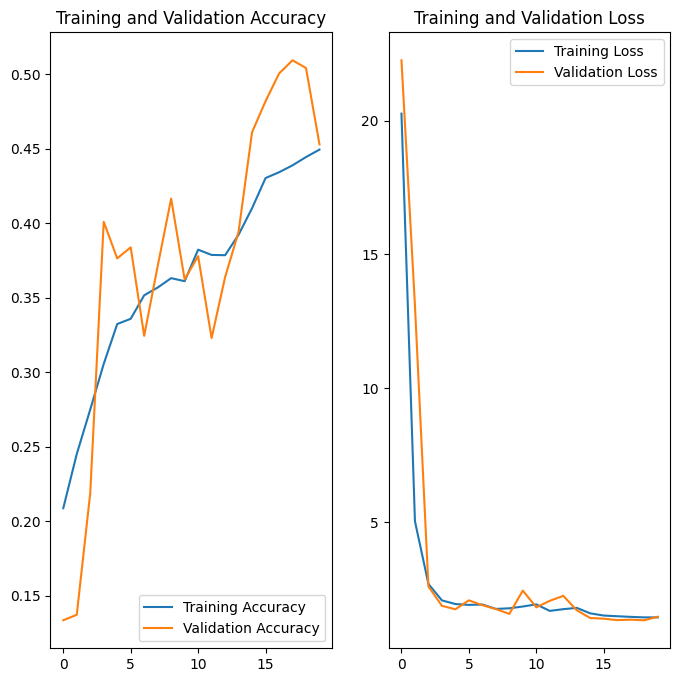

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings:

1. The model seems to be underfitting also the training and validation accuracy has reduced compared to the previous model.

2. The model needs to be trained with more data and more epochs for a better fit.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
# images in each classes
class_diff=pd.DataFrame()
for i in range(len(class_names)):
  name= class_names[i]
  number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)

print(class_diff)

                        class  number
0           actinic keratosis     114
1        basal cell carcinoma     376
2              dermatofibroma      95
3                    melanoma     438
4                       nevus     357
5  pigmented benign keratosis     462
6        seborrheic keratosis      77
7     squamous cell carcinoma     181
8             vascular lesion     139


<ipython-input-23-0ecb82e1010f>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipython-input-23-0ecb82e1010f>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipython-input-23-0ecb82e1010f>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipython-input-23-0ecb82e1010f>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipy

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?

Findings:

Least number of samples : seborrheic keratosis(77), dermatofibroma
(95)

Most number of samples: pigmented benign keratosis(462), melanoma    (438)

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [24]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CEA96223CA0>: 100%|██████████| 500/500 [00:24<00:00, 20.32 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CEA96B7BB80>: 100%|██████████| 500/500 [00:24<00:00, 20.28 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CEA97707640>: 100%|██████████| 500/500 [00:24<00:00, 20.44 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1936x1296 at 0x7CEA96DAA080>: 100%|██████████| 500/500 [01:40<00:00,  4.98 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x7CEA97591960>: 100%|██████████| 500/500 [01:32<00:00,  5.43 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CEA960648B0>: 100%|██████████| 500/500 [00:20<00:00, 24.52 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7CEA9603D840>: 100%|██████████| 500/500 [00:41<00:00, 12.00 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CEA96DB3CA0>: 100%|██████████| 500/500 [00:21<00:00, 22.98 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CEA96C50820>: 100%|██████████| 500/500 [00:19<00:00, 25.42 Samples/s]


In [26]:
from glob import glob
path_list_new = list(glob(os.path.join(data_dir_train, '*','output', '*.jpg')))
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010321.jpg_59b24861-56ca-42dc-a78e-295513d655c7.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010690.jpg_86ef6b8b-e0d4-4b7a-b7f5-b7f6145583d5.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009960.jpg_f5638b91-59d9-43dd-9484-8210e4a026b8.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010165.jpg_b9326467-c3de-4c04-afbb-71a1b7127ca8.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010029.jpg_0a57e924-4d3a-422a-b83f-8a71e2b85bbe.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010289.jpg_24656c3c-ec69-40c3-86a6-eae4fd2adfb0.jpg',
 'Skin cancer IS

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(glob(os.path.join(data_dir_train, '*/output/*.jpg'))))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
path_list = [x for x in (glob(os.path.join(data_dir_train, '*','output', '*.jpg')))]
#list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010321.jpg_59b24861-56ca-42dc-a78e-295513d655c7.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010690.jpg_86ef6b8b-e0d4-4b7a-b7f5-b7f6145583d5.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009960.jpg_f5638b91-59d9-43dd-9484-8210e4a026b8.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010165.jpg_b9326467-c3de-4c04-afbb-71a1b7127ca8.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010029.jpg_0a57e924-4d3a-422a-b83f-8a71e2b85bbe.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010289.jpg_24656c3c-ec69-40c3-86a6-eae4fd2adfb0.jpg',
 'Skin cancer IS

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [30]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [31]:
for i in class_names:
    directory ='Skin cancer ISIC The International Skin Imaging Collaboration/Train'
    directory_out ='Skin cancer ISIC The International Skin Imaging Collaboration/Train'+'/'+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob(i+'/*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 1114 samples.
basal cell carcinoma has 1376 samples.
dermatofibroma has 1095 samples.
melanoma has 1438 samples.
nevus has 1357 samples.
pigmented benign keratosis has 1462 samples.
seborrheic keratosis has 1077 samples.
squamous cell carcinoma has 1181 samples.
vascular lesion has 1139 samples.


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [32]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [33]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [34]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [35]:
## your code goes here

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3)))
model.add(data_augmentation)
model.add(Conv2D(32, kernel_size=(3,3), padding = 'Same', activation = 'relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), padding = 'Same', activation = 'relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,kernel_size=(3,3),padding = 'Same', activation = 'relu' ))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=(3,3),padding = 'Same', activation = 'relu' ))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation ='relu',kernel_regularizer=regularizers.L2(0.01)))
model.add(Dropout(0.25))
model.add(Dense(9,activation='softmax'))

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_10 (Ba  (None, 180, 180, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_13 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization_11 (Ba  (None, 180, 180, 32)      128       
 tchNormalization)                                    

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [36]:
## your code goes here
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2,min_lr=1e-5)

opt=tf.keras.optimizers.Adam()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_10 (Ba  (None, 180, 180, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_13 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization_11 (Ba  (None, 180, 180, 32)      128       
 tchNormalization)                                    

#### **Todo:**  Train your model

In [ ]:
## Your code goes here, use 50 epochs.
epochs = 50

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[learn_control]
)

Epoch 1/50
281/281 [==============================] - 91s 267ms/step - loss: 16.6350 - accuracy: 0.2163 - val_loss: 35.3129 - val_accuracy: 0.0850 - lr: 0.0010
Epoch 2/50
281/281 [==============================] - 70s 246ms/step - loss: 3.0629 - accuracy: 0.2889 - val_loss: 3.1869 - val_accuracy: 0.2150 - lr: 0.0010
Epoch 3/50
281/281 [==============================] - 67s 234ms/step - loss: 2.0028 - accuracy: 0.3216 - val_loss: 1.7362 - val_accuracy: 0.4005 - lr: 0.0010
Epoch 4/50
281/281 [==============================] - 69s 242ms/step - loss: 1.8321 - accuracy: 0.3423 - val_loss: 1.6208 - val_accuracy: 0.4201 - lr: 0.0010
Epoch 5/50
281/281 [==============================] - 69s 243ms/step - loss: 1.7796 - accuracy: 0.3653 - val_loss: 2.6066 - val_accuracy: 0.2955 - lr: 0.0010
Epoch 6/50
281/281 [==============================] - 67s 236ms/step - loss: 1.7082 - accuracy: 0.3752 - val_loss: 2.6190 - val_accuracy: 0.2804 - lr: 0.0010
Epoch 7/50
281/281 [==============================

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

